In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
tqdm.pandas()
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors
import CityHub
import glob

/tmp/ipykernel_324717/184408677.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
month_range = ["2019-04-01", "2023-01-01"]
day_range = ["2019-04-01", "2020-01-01"]

In [4]:
def crossref(df, gdf):
    shapes = gdf.geometry
    centroids = [x.centroid for x in shapes]
    centroids = np.array([(x.x, x.y) for x in centroids])
    nn = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(centroids)
    _, indices = nn.kneighbors(df[['LONGITUDE', 'LATITUDE']])

    id_poly = []
    i = 0
    for _, row in tqdm(df.iterrows(), total=len(df)):
        point = Point(row['LONGITUDE'], row['LATITUDE'])
        new_id = None
        for idx in indices[i]:
            if shapes[idx].contains(point):
                new_id = idx
                break
        id_poly.append(new_id)
        i += 1

    df['id_poly'] = id_poly
    return df
    

In [5]:
def groupby_month(df):
    df["year"] = df.date.dt.year
    df["month"] = df.date.dt.month
    df = df.groupby(["id_poly", "year", "month"]).size().reset_index()
    df.columns = ["id_poly", "year", "month", "count"]
    df["id_poly"] = df["id_poly"].astype(int)
    return df

def transform_month_to_ts(df, gdf):
    start_year = pd.to_datetime(month_range[0]).year
    start_month = pd.to_datetime(month_range[0]).month
    end_year = pd.to_datetime(month_range[1]).year
    end_month = pd.to_datetime(month_range[1]).month
    n_months = (end_year - start_year) * 12 + end_month - start_month 

    n_poly = len(gdf)

    ts = np.zeros((n_poly, n_months))
    k = 0
    for m in range(start_month, 13):
        filtered = df[(df.year == start_year) & (df.month == m)]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        elif len(filtered) > 0:
            ts[filtered.id_poly, k] = filtered["count"]
        k += 1

    for y in range(start_year + 1, end_year):
        for m in range(1, 13):
            filtered = df[(df.year == y) & (df.month == m)]
            if len(filtered) == ts.shape[0]:
                ts[:, k] = filtered["count"]
            elif len(filtered) > 0:
                ts[filtered.id_poly, k] = filtered["count"]
            k += 1

    for m in range(1, end_month + 1):
        filtered = df[(df.year == end_year) & (df.month == m)]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        elif len(filtered) > 0:
            ts[filtered.id_poly, k] = filtered["count"]
        k += 1
        
    return ts


def groupby_day(df):
    day_ns = 60*60*24*10**9
    df["date_int"] = df.date.astype(int)
    df["date_int"] = df.date_int / day_ns
    df["date_int"] = df.date_int.astype(int)    
    df = df.groupby(["id_poly", "date_int"]).size().reset_index()
    df.columns = ["id_poly", "date_int", "count"]
    df["id_poly"] = df["id_poly"].astype(int)
    df = df.sort_values(["id_poly", "date_int"])
    return df


def transform_day_to_ts(df, gdf):
    min_date = pd.to_datetime(day_range[0]).date().toordinal()
    max_date = pd.to_datetime(day_range[1]).date().toordinal()
    n_days = max_date - min_date 
    n_poly = len(gdf)
    ts = np.zeros((n_poly, n_days))
    k = 0
    for day in range(min_date, max_date):
        filtered = df[df.date_int == day]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        else:
        # fill missing values with 0
            ts[:, k] = 0
            ts[filtered.id_poly, k] = filtered["count"]
        k += 1

    return ts


def create_sp_timeseries(df, gdf, df_name, gdf_name):
    df_poly = crossref(df, gdf)
    print(f"Number of points: {len(df_poly)}")
    print(f"Number of points without polygon: {df_poly.id_poly.isna().sum()/len(df_poly)*100:.2f}%")
    df_poly = df_poly.dropna(subset = ["id_poly"])
    df_poly.to_csv(f"data/geo_data/{df_name}_{gdf_name}.csv", index=False)


    df_poly_month = df_poly[(df_poly.date >= month_range[0]) & (df_poly.date < month_range[1])].copy()
    df_poly_month = groupby_month(df_poly_month)
    ts_month = transform_month_to_ts(df_poly_month, gdf)
    print(f"Number of months: {ts_month.shape[1]}")
    np.save(f"data/time_series/{df_name}_{gdf_name}_Month.npy", ts_month)

    df_poly_day = df_poly[(df_poly.date >= day_range[0]) & (df_poly.date < day_range[1])].copy()
    df_poly_day = groupby_day(df_poly_day)
    ts_day = transform_day_to_ts(df_poly_day, gdf)
    print(f"Number of days: {ts_day.shape[1]}")
    np.save(f"data/time_series/{df_name}_{gdf_name}_Day.npy", ts_day)


## Climate

In [52]:
for station in ["MIRANTE", "BARUERI", "INTERLAGOS"]:
    files = glob.glob(f"data/time_series/*{station}*")
    file_2018 = [f for f in files if f.find("2018") != -1][0]
    other_files = files.copy()
    other_files.remove(file_2018)
    files = other_files + [file_2018]
    df = []
    for file in files:
        df_ = pd.read_csv(file, sep = ";")
        if file == files[0]:
            columns = df_.columns
        
        if file == files[-1]: # 2018 file, a bit problematic
            df_.columns = columns
            df_["date"] = pd.to_datetime(df_["Data"], format = "%Y-%m-%d")
        else:
            df_["date"] = pd.to_datetime(df_["Data"], format = "%Y/%m/%d")
        df.append(df_)
    df = pd.concat(df)
    selected_columns = ["date", 'PRECIPITA��O TOTAL, HOR�RIO (mm)', 'TEMPERATURA M�XIMA NA HORA ANT. (AUT) (�C)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)']
    df = df[selected_columns]
    df.columns = ["date", "precipitation", "temperature", "humidity"]
    df["precipitation"] = df["precipitation"].str.replace(",", ".").astype(float)
    df["temperature"] = df["temperature"].str.replace(",", ".").astype(float)
    # fill na values with mean
    df["temperature"] = df["temperature"].fillna(df["temperature"].mean())
    df["humidity"] = df["humidity"].fillna(df["humidity"].mean())
    df["precipitation"] = df["precipitation"].fillna(0)
    #df = df.dropna()
    df_full = df.copy()
    df = df_full.groupby("date").agg({"precipitation": "sum", "temperature": ["min", "max", "mean"], "humidity": "mean"}).reset_index()
    df.columns = ["Data", "precipitation", "temperature_min", "temperature_max", "temperature", "humidity_mean"]
    # add hour to date
    df["Data"] = pd.to_datetime(df["Data"])
    df["Data"] = df["Data"].dt.floor('h')
    
    df["Data"] = df["Data"].dt.strftime("%Y-%d-%m %H:%M:%S")
    df.to_csv(f"data/geo_data/{station}_weather_Day.csv", sep = ";", index=False)

    df_full["month_year"] = df_full["date"].dt.month.astype(str) + "-" + df_full["date"].dt.year.astype(str)
    df = df_full.groupby("month_year").agg({"date" : "max", "precipitation": "sum", "temperature": ["min", "max", "mean"], "humidity": "mean"}).reset_index()
    df.columns = ["month_year", "Data", "precipitation", "temperature_min", "temperature_max", "temperature", "humidity_mean"]
    df = df.drop(columns = ["month_year"])
    # add hour to date
    df["Data"] = pd.to_datetime(df["Data"])
    df["Data"] = df["Data"].dt.floor('h')
    
    df["Data"] = df["Data"].dt.strftime("%Y-%d-%m %H:%M:%S")
    df.to_csv(f"data/geo_data/{station}_weather_Month.csv", sep = ";", index=False)

In [23]:
ch = CityHub.CityHub("Sao Paulo, Brazil")

Loading file...


Preprocessing city mesh...
Refining mesh...


/home/giovani/Documents/AutoSatViewer/wavelet_code/CityHub.py:206: FutureWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error starting in the v2.0.0 release.
  great_circle_dist = ox.distance.great_circle_vec(vertA[0],vertA[1],vertB[0],vertB[1])
/home/giovani/Documents/AutoSatViewer/wavelet_code/CityHub.py:207: FutureWarning: The `euclidean_dist_vec` function has been renamed `euclidean`. Calling `euclidean_dist_vec` will raise an error starting in the v2.0.0 release.
  latlong_dist = ox.distance.euclidean_dist_vec(vertA[0],vertA[1],vertB[0],vertB[1])


In [53]:
time_interval = "Month"
poly_division = "SpCenterCensus10k"

for station in ["MIRANTE", "BARUERI", "INTERLAGOS"]:
    ch.load_SMLayers_known_measurements(station, f"data/geo_data/{station}_weather_{time_interval}.csv")
ch.load_SMLayers_measurements_points_info("data/geo_data/Stations_info.csv");



gdf = gpd.read_file(f"data/shapefiles/{poly_division}.shp")
gdf["lat"] = gdf.centroid.y
gdf["lng"] = gdf.centroid.x
for feature in ["temperature", "precipitation"]:
    poly_feature = ch.sparse_ts_estimation(feature, month_range[0], month_range[1], gdf, "lat", "lng")
    poly_feature = poly_feature.T.reset_index()
    poly_feature = poly_feature[poly_feature.Data >= month_range[0]]
    poly_feature = poly_feature[poly_feature.Data < month_range[1]]
    poly_feature = poly_feature.iloc[:, 1:]

    ts = poly_feature.values.T
    print(ts.shape)
    np.save(f"data/time_series/{feature}_{poly_division}_{time_interval}.npy", ts)

(10000, 45)
(10000, 45)


/tmp/ipykernel_266984/1369965686.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.centroid.y
/tmp/ipykernel_266984/1369965686.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lng"] = gdf.centroid.x
/home/giovani/Documents/AutoSatViewer/wavelet_code/CityHub.py:1188: FutureWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error starting in the v2.0.0 release.
  sigma = .5*np.mean([ ox.distance.great_circle_vec(Xm[i,0],Xm[i,1],Xm[j,0],Xm[j,1]) for i in range(M) for j in range(1+i,M)])
/home/giovani/Documents/AutoSatViewer/wavelet_code/CityHub.py:1139: FutureWarning: The `great_circle_vec` function has been renamed `gre

In [54]:
time_interval = "Month"
poly_division = "SpDistricts"

for station in ["MIRANTE", "BARUERI", "INTERLAGOS"]:
    ch.load_SMLayers_known_measurements(station, f"data/geo_data/{station}_weather_{time_interval}.csv")
ch.load_SMLayers_measurements_points_info("data/geo_data/Stations_info.csv");



gdf = gpd.read_file(f"data/shapefiles/{poly_division}.shp")
gdf["lat"] = gdf.centroid.y
gdf["lng"] = gdf.centroid.x
for feature in ["temperature", "precipitation"]:
    poly_feature = ch.sparse_ts_estimation(feature, month_range[0], month_range[1], gdf, "lat", "lng")
    poly_feature = poly_feature.T.reset_index()
    poly_feature = poly_feature[poly_feature.Data >= month_range[0]]
    poly_feature = poly_feature[poly_feature.Data < month_range[1]]
    poly_feature = poly_feature.iloc[:, 1:]

    ts = poly_feature.values.T
    print(ts.shape)
    np.save(f"data/time_series/{feature}_{poly_division}_{time_interval}.npy", ts)

(96, 45)
(96, 45)


/tmp/ipykernel_266984/225899637.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.centroid.y
/tmp/ipykernel_266984/225899637.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lng"] = gdf.centroid.x
/home/giovani/Documents/AutoSatViewer/wavelet_code/CityHub.py:1188: FutureWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error starting in the v2.0.0 release.
  sigma = .5*np.mean([ ox.distance.great_circle_vec(Xm[i,0],Xm[i,1],Xm[j,0],Xm[j,1]) for i in range(M) for j in range(1+i,M)])
/home/giovani/Documents/AutoSatViewer/wavelet_code/CityHub.py:1139: FutureWarning: The `great_circle_vec` function has been renamed `great

In [55]:
time_interval = "Day"
poly_division = "SpCenterCensus10k"

for station in ["MIRANTE", "BARUERI", "INTERLAGOS"]:
    ch.load_SMLayers_known_measurements(station, f"data/geo_data/{station}_weather_{time_interval}.csv")
ch.load_SMLayers_measurements_points_info("data/geo_data/Stations_info.csv");



gdf = gpd.read_file(f"data/shapefiles/{poly_division}.shp")
gdf["lat"] = gdf.centroid.y
gdf["lng"] = gdf.centroid.x
for feature in ["temperature", "precipitation"]:
    poly_feature = ch.sparse_ts_estimation(feature, month_range[0], month_range[1], gdf, "lat", "lng")
    poly_feature = poly_feature.T.reset_index()
    poly_feature = poly_feature[poly_feature.Data >= day_range[0]]
    poly_feature = poly_feature[poly_feature.Data < day_range[1]]
    poly_feature = poly_feature.iloc[:, 1:]

    ts = poly_feature.values.T
    print(ts.shape)
    np.save(f"data/time_series/{feature}_{poly_division}_{time_interval}.npy", ts)

/tmp/ipykernel_266984/1594469053.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.centroid.y
/tmp/ipykernel_266984/1594469053.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lng"] = gdf.centroid.x
/home/giovani/Documents/AutoSatViewer/wavelet_code/CityHub.py:1188: FutureWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error starting in the v2.0.0 release.
  sigma = .5*np.mean([ ox.distance.great_circle_vec(Xm[i,0],Xm[i,1],Xm[j,0],Xm[j,1]) for i in range(M) for j in range(1+i,M)])
/home/giovani/Documents/AutoSatViewer/wavelet_code/CityHub.py:1139: FutureWarning: The `great_circle_vec` function has been renamed `gre

(10000, 275)
(10000, 275)


In [56]:
time_interval = "Day"
poly_division = "SpDistricts"

for station in ["MIRANTE", "BARUERI", "INTERLAGOS"]:
    ch.load_SMLayers_known_measurements(station, f"data/geo_data/{station}_weather_{time_interval}.csv")
ch.load_SMLayers_measurements_points_info("data/geo_data/Stations_info.csv");



gdf = gpd.read_file(f"data/shapefiles/{poly_division}.shp")
gdf["lat"] = gdf.centroid.y
gdf["lng"] = gdf.centroid.x
for feature in ["temperature", "precipitation"]:
    poly_feature = ch.sparse_ts_estimation(feature, month_range[0], month_range[1], gdf, "lat", "lng")
    poly_feature = poly_feature.T.reset_index()
    poly_feature = poly_feature[poly_feature.Data >= day_range[0]]
    poly_feature = poly_feature[poly_feature.Data < day_range[1]]
    poly_feature = poly_feature.iloc[:, 1:]

    ts = poly_feature.values.T
    print(ts.shape)
    np.save(f"data/time_series/{feature}_{poly_division}_{time_interval}.npy", ts)

(96, 275)
(96, 275)


/tmp/ipykernel_266984/794070639.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.centroid.y
/tmp/ipykernel_266984/794070639.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lng"] = gdf.centroid.x
/home/giovani/Documents/AutoSatViewer/wavelet_code/CityHub.py:1188: FutureWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error starting in the v2.0.0 release.
  sigma = .5*np.mean([ ox.distance.great_circle_vec(Xm[i,0],Xm[i,1],Xm[j,0],Xm[j,1]) for i in range(M) for j in range(1+i,M)])
/home/giovani/Documents/AutoSatViewer/wavelet_code/CityHub.py:1139: FutureWarning: The `great_circle_vec` function has been renamed `great

## Waze

In [6]:
N = 1000000
df = pd.read_csv("data/time_series/waze-alerts.csv")
df = df.sample(N, random_state = 0)
print(df.shape)
df.columns

(1000000, 6)


Index(['geo', 'ts', ' type', ' subtype', ' reliability', ' confidence'], dtype='object')

In [7]:
df["date"] = pd.to_datetime(df["ts"])
df["LONGITUDE"] = df["geo"].apply(lambda x : x.split("(")[1].split(" ")[0])
df["LATITUDE"] = df["geo"].apply(lambda x : x.split(" ")[1].split(")")[0])
df.LONGITUDE = df.LONGITUDE.astype(float)
df.LATITUDE = df.LATITUDE.astype(float)

In [8]:
df[" type"].value_counts()

 type
JAM              714622
WEATHERHAZARD    224556
ACCIDENT          30251
HAZARD            21986
ROAD_CLOSED        8585
Name: count, dtype: int64

In [9]:
# change ROAD_CLOSED to ROADCLOSED
df[" type"] = df[" type"].apply(lambda x : "ROADCLOSED" if x == "ROAD_CLOSED" else x)

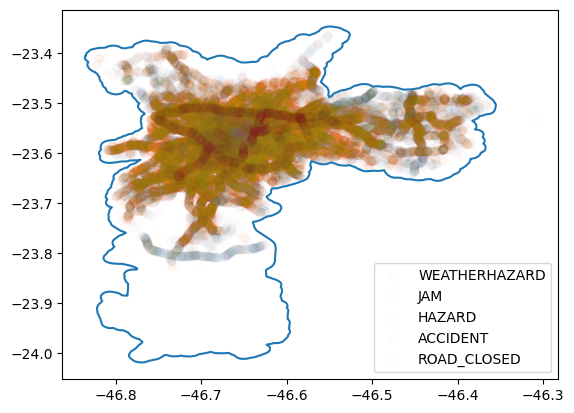

In [34]:
countour = gpd.read_file("data/countour.geojson")
plt.plot(countour.geometry[0].exterior.xy[0], countour.geometry[0].exterior.xy[1])
for ty in df[" type"].unique():
    df_filter = df[df[" type"] == ty]
    plt.scatter(df_filter['LONGITUDE'], df_filter['LATITUDE'], alpha = 0.01, label = ty)
plt.legend()
plt.show()

In [10]:
alerts_types = df[" type"].unique()

for ty in alerts_types:
    df_filter = df[df[" type"] == ty].copy()
    gdf = gpd.read_file("data/shapefiles/SpDistricts.shp")
    create_sp_timeseries(df_filter, gdf, f"Waze{ty}", "SpDistricts")

/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 224556/224556 [00:38<00:00, 5835.59it/s]


Number of points: 224556
Number of points without polygon: 3.21%
Number of months: 45
Number of days: 275


/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 714622/714622 [01:55<00:00, 6183.97it/s]


Number of points: 714622
Number of points without polygon: 2.78%
Number of months: 45
Number of days: 275


/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 21986/21986 [00:03<00:00, 5855.37it/s]


Number of points: 21986
Number of points without polygon: 3.09%
Number of months: 45


/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


Number of days: 275


100%|██████████| 30251/30251 [00:05<00:00, 5832.83it/s]


Number of points: 30251
Number of points without polygon: 3.58%
Number of months: 45
Number of days: 275


/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 8585/8585 [00:01<00:00, 6449.16it/s]


Number of points: 8585
Number of points without polygon: 2.31%
Number of months: 45
Number of days: 275


In [11]:
alerts_types = df[" type"].unique()

for ty in alerts_types:
    df_filter = df[df[" type"] == ty].copy()
    gdf = gpd.read_file("data/shapefiles/SpCenterCensus10k.shp")
    create_sp_timeseries(df_filter, gdf, f"Waze{ty}", "SpCenterCensus10k")

/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 224556/224556 [00:24<00:00, 9076.44it/s]


Number of points: 224556
Number of points without polygon: 54.69%
Number of months: 45
Number of days: 275


/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 714622/714622 [01:18<00:00, 9048.98it/s]


Number of points: 714622
Number of points without polygon: 45.40%
Number of months: 45
Number of days: 275


/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 21986/21986 [00:02<00:00, 9305.46it/s]


Number of points: 21986
Number of points without polygon: 52.70%
Number of months: 45
Number of days: 275


/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 30251/30251 [00:03<00:00, 9126.03it/s]


Number of points: 30251
Number of points without polygon: 55.60%
Number of months: 45
Number of days: 275


/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 8585/8585 [00:00<00:00, 9063.80it/s]


Number of points: 8585
Number of points without polygon: 46.38%
Number of months: 45
Number of days: 275


## Crime theft

In [5]:
df = pd.read_csv("data/time_series/furto_celular_2018_2022.csv", sep = ";")
# drop columns with more than 0.1 of missing values
df["date"] = pd.to_datetime(df.DATAOCORRENCIA, format='%d/%m/%Y', errors='coerce')
df = df.dropna(thresh=0.9*len(df), axis=1)
df = df.dropna()
df = df.drop(columns = ["ANO_BO", "DATAOCORRENCIA"], axis = 1)
df = df[df.date > "2018-01-01"]
df = df.reset_index(drop=True)
df.shape

/tmp/ipykernel_161898/2216112243.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/time_series/furto_celular_2018_2022.csv", sep = ";")


(389397, 13)

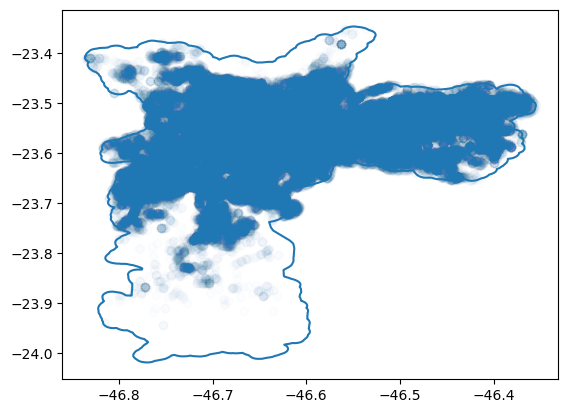

In [45]:
countour = gpd.read_file("data/countour.geojson")
plt.plot(countour.geometry[0].exterior.xy[0], countour.geometry[0].exterior.xy[1])
plt.scatter(df['LONGITUDE'], df['LATITUDE'], alpha = 0.01)
plt.show()

In [46]:
gdf = gpd.read_file("data/shapefiles/SpDistricts.shp")
create_sp_timeseries(df, gdf, "FurtoCelular", "SpDistricts")

/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 389397/389397 [01:05<00:00, 5917.02it/s]


Number of points: 389397
Number of points without polygon: 4.55%
Number of months: 45
Number of days: 275


In [47]:
gdf = gpd.read_file("data/shapefiles/SpCenterCensus10k.shp")
create_sp_timeseries(df, gdf, "FurtoCelular", "SpCenterCensus10k")

/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 389397/389397 [00:43<00:00, 8959.85it/s]


Number of points: 389397
Number of points without polygon: 46.94%
Number of months: 45
Number of days: 275


## Crime robbery

In [48]:
df = pd.read_csv("data/time_series/roubo_celular_2018_2022.csv", sep = ";")
# drop columns with more than 0.1 of missing values
df["date"] = pd.to_datetime(df.DATAOCORRENCIA, format='%d/%m/%Y', errors='coerce')
df = df.dropna(thresh=0.9*len(df), axis=1)
df = df.dropna()
df = df.drop(columns = ["ANO_BO", "DATAOCORRENCIA"], axis = 1)
df = df[df.date > "2018-01-01"]
df = df.reset_index(drop=True)
df.shape

/tmp/ipykernel_97917/1213486941.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/time_series/roubo_celular_2018_2022.csv", sep = ";")


(588122, 14)

In [49]:
gdf = gpd.read_file("data/shapefiles/SpDistricts.shp")
create_sp_timeseries(df, gdf, "RouboCelular", "SpDistricts")

/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 588122/588122 [02:02<00:00, 4803.19it/s]


Number of points: 588122
Number of points without polygon: 11.03%
Number of months: 45
Number of days: 275


In [50]:
gdf = gpd.read_file("data/shapefiles/SpCenterCensus10k.shp")
create_sp_timeseries(df, gdf, "RouboCelular", "SpCenterCensus10k")

/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 588122/588122 [01:03<00:00, 9205.47it/s]


Number of points: 588122
Number of points without polygon: 72.29%
Number of months: 45
Number of days: 275


## Unify time-series

In [12]:
poly_division = "SpDistricts"
time_interval = "Month"
df = []
signals = ["WazeACCIDENT", "WazeHAZARD", "WazeJAM", "WazeROADCLOSED", "WazeWEATHERHAZARD", "FurtoCelular", "RouboCelular", "temperature", "precipitation"]
ts = [
    np.load(f"data/time_series/{signal}_{poly_division}_{time_interval}.npy") for signal in signals
]
date = pd.date_range(start = month_range[0], end = month_range[1], freq = "M")
poly_id = np.arange(ts[0].shape[0])


for poly in range(ts[0].shape[0]):
    for t in range(ts[0].shape[1]):
        df.append({
            "date" : date[t],
            "id_poly" : poly_id[poly],
        })
        for i, signal in enumerate(signals):
            df[-1][signal] = ts[i][poly, t]

df = pd.DataFrame(df)
print(df.shape)
df.to_csv(f"data/polygon_data/{poly_division}_{time_interval}.csv", index=False)

(4320, 11)


/tmp/ipykernel_324717/1139238529.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date = pd.date_range(start = month_range[0], end = month_range[1], freq = "M")


In [13]:
poly_division = "SpDistricts"
time_interval = "Day"
df = []
signals = ["WazeACCIDENT", "WazeHAZARD", "WazeJAM", "WazeROADCLOSED", "WazeWEATHERHAZARD", "FurtoCelular", "RouboCelular", "temperature", "precipitation"]
ts = [
    np.load(f"data/time_series/{signal}_{poly_division}_{time_interval}.npy") for signal in signals
]
date = pd.date_range(start = day_range[0], end = day_range[1], freq = "D")
poly_id = np.arange(ts[0].shape[0])


for poly in range(ts[0].shape[0]):
    for t in range(ts[0].shape[1]):
        df.append({
            "date" : date[t],
            "id_poly" : poly_id[poly],
        })
        for i, signal in enumerate(signals):
            df[-1][signal] = ts[i][poly, t]

df = pd.DataFrame(df)
print(df.shape)
df.to_csv(f"data/polygon_data/{poly_division}_{time_interval}.csv", index=False)

(26400, 11)


In [14]:
poly_division = "SpCenterCensus10k"
time_interval = "Month"
df = []
signals = ["WazeACCIDENT", "WazeHAZARD", "WazeJAM", "WazeROADCLOSED", "WazeWEATHERHAZARD", "FurtoCelular", "RouboCelular", "temperature", "precipitation"]
ts = [
    np.load(f"data/time_series/{signal}_{poly_division}_{time_interval}.npy") for signal in signals
]
date = pd.date_range(start = month_range[0], end = month_range[1], freq = "M")
poly_id = np.arange(ts[0].shape[0])


for poly in range(ts[0].shape[0]):
    for t in range(ts[0].shape[1]):
        df.append({
            "date" : date[t],
            "id_poly" : poly_id[poly],
        })
        for i, signal in enumerate(signals):
            df[-1][signal] = ts[i][poly, t]

df = pd.DataFrame(df)
print(df.shape)
df.to_csv(f"data/polygon_data/{poly_division}_{time_interval}.csv", index=False)

/tmp/ipykernel_324717/965197216.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date = pd.date_range(start = month_range[0], end = month_range[1], freq = "M")


(450000, 11)


In [15]:
poly_division = "SpCenterCensus10k"
time_interval = "Day"
df = []
signals = ["WazeACCIDENT", "WazeHAZARD", "WazeJAM", "WazeROADCLOSED", "WazeWEATHERHAZARD", "FurtoCelular", "RouboCelular", "temperature", "precipitation"]
ts = [
    np.load(f"data/time_series/{signal}_{poly_division}_{time_interval}.npy") for signal in signals
]
date = pd.date_range(start = day_range[0], end = day_range[1], freq = "D")
poly_id = np.arange(ts[0].shape[0])


for poly in range(ts[0].shape[0]):
    for t in range(ts[0].shape[1]):
        df.append({
            "date" : date[t],
            "id_poly" : poly_id[poly],
        })
        for i, signal in enumerate(signals):
            df[-1][signal] = ts[i][poly, t]

df = pd.DataFrame(df)
print(df.shape)
df.to_csv(f"data/polygon_data/{poly_division}_{time_interval}.csv", index=False)

(2750000, 11)
